<a href="https://colab.research.google.com/github/Ishanml/Credit-Card-Defaults-Classification/blob/main/UCI_Credit_Card_analysis_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'default-of-credit-card-clients-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F306%2F666%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240829%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240829T070417Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D93bb429fe1ac49abddcdb317c28c61f0cbc982f7a40e03da175d0024e867906a583368e51184be5bf5651889424eeb5ef74cb74b1e09497c233319228614670e900bb59f26f5d92dbae87f6a032f81b7ca8f6d300bab35105bb6bf58b7851b0a0e25cbd4c5ae5755588eb6aa995a58333f125956454905dc1db6e3c354f3f23c444f1b42216780446975771b1c2508bf6d7b2d8c531bad307a80aee85dda587d790e6af04d7c7da6aa8888f48a2f5871bc0c6b8475af89aa6e92de72ceb67cc8dc6c438f72a532fa85115113ce852a44e8b40efed8fecdb043e4f14c7b801c20c8dd2892f2df55ab405417c20190fe694b58502e29009b539b0bea9a34bbfb28'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1025318 bytes downloaded
Downloaded and uncompressed: default-of-credit-card-clients-dataset
Data source import complete.


# Importing Packages

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,accuracy_score, RocCurveDisplay # Import RocCurveDisplay instead
pd.set_option('display.max_columns',25)
warnings.filterwarnings('ignore')

In [103]:
# Importing Dataset
data = pd.read_csv(r'../input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
data.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,0,0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
7,8,100000.0,2,2,2,23,0,-1,-1,0,0,-1,11876.0,380.0,601.0,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
8,9,140000.0,2,3,1,28,0,0,2,0,0,0,11285.0,14096.0,12108.0,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
9,10,20000.0,1,3,2,35,-2,-2,-2,-2,-1,-1,0.0,0.0,0.0,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0


In [104]:
data.info()
#info shows that there is no null values and all the features are numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [105]:
data.describe(include='all') # Descriptive analysis

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [106]:
data.rename(columns={'PAY_0':'PAY_1','default.payment.next.month':'def_pay'},inplace=True)
#rename few columns

# Exploratory Data Analysis

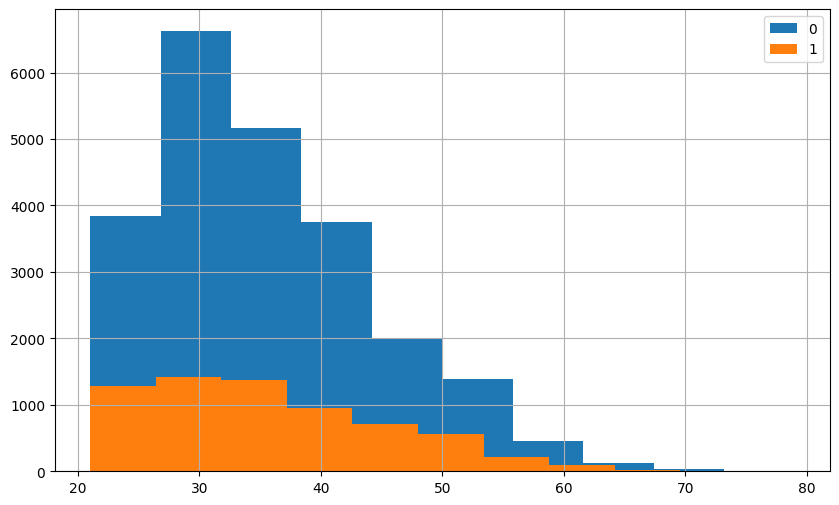

In [107]:
plt.figure(figsize=(10,6))
data.groupby('def_pay')['AGE'].hist(legend=True)
plt.show()
#here we can see that, between age 20 to 45 most of the people will fall into..

Text(0.5, 1.0, 'Age Distribution')

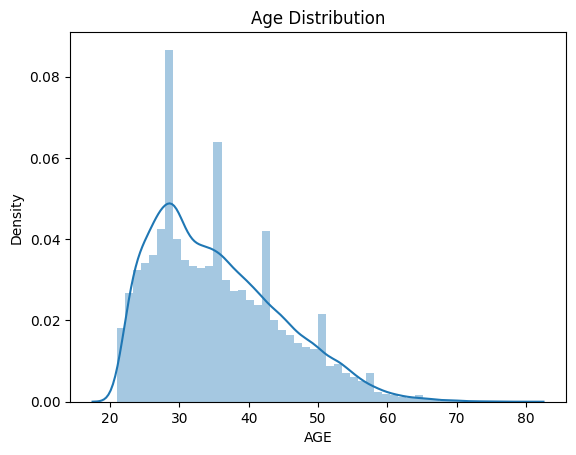

In [108]:
sns.distplot(data['AGE'])
plt.title('Age Distribution')

<Axes: xlabel='def_pay', ylabel='LIMIT_BAL'>

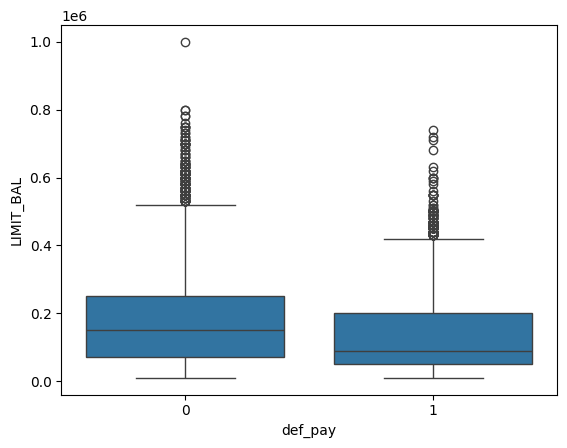

In [110]:
sns.boxplot(x='def_pay', y='LIMIT_BAL', data=data)

In [111]:
data[data['LIMIT_BAL']>700000].sort_values(ascending=False,by='LIMIT_BAL')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
2197,2198,1000000.0,2,1,1,47,0,0,0,-1,0,0,964511.0,983931.0,535020.0,891586.0,927171.0,961664.0,50784.0,50723.0,896040.0,50000.0,50000.0,50256.0,0
18006,18007,800000.0,1,1,2,46,-2,-2,-2,-1,-1,-1,6229.0,4636.0,3810.0,6193.0,1957.0,3175.0,4644.0,3832.0,6219.0,1961.0,3183.0,27201.0,0
14919,14920,800000.0,1,2,1,53,-1,-1,-1,0,0,-1,7639.0,5552.0,64535.0,40814.0,12590.0,9339.0,11145.0,64657.0,131.0,247.0,9366.0,63482.0,0
28715,28716,780000.0,2,2,2,41,-2,-2,-2,-2,-2,-2,101957.0,61715.0,38686.0,21482.0,72628.0,182792.0,62819.0,39558.0,22204.0,82097.0,184322.0,25695.0,0
24320,24321,780000.0,1,1,1,48,0,0,0,0,0,0,171459.0,178587.0,190663.0,195124.0,184872.0,191090.0,10000.0,15004.0,10000.0,8000.0,10028.0,7003.0,0
21375,21376,760000.0,1,3,1,54,0,0,0,0,0,0,447670.0,455970.0,462497.0,469931.0,474421.0,480598.0,20011.0,19500.0,19019.0,18003.0,20000.0,22000.0,0
13186,13187,750000.0,2,1,2,28,1,-1,-1,0,0,-1,9500.0,9655.0,401003.0,399493.0,400993.0,409483.0,250000.0,401003.0,7990.0,11000.0,417990.0,3080.0,0
3733,3734,750000.0,2,2,1,43,-1,-1,-1,-2,-1,-1,72495.0,99628.0,74635.0,63749.0,85067.0,83208.0,99664.0,74640.0,63758.0,85072.0,83215.0,124063.0,0
10089,10090,750000.0,2,1,1,41,0,0,0,0,-1,-1,184022.0,163441.0,92767.0,75696.0,35485.0,4889.0,6817.0,2330.0,2705.0,50854.0,4913.0,550.0,0
4603,4604,750000.0,2,3,1,40,-2,-2,-1,-1,-1,-1,16372.0,15344.0,3329.0,38488.0,9777.0,66692.0,15420.0,3691.0,38679.0,9825.0,67024.0,76641.0,0


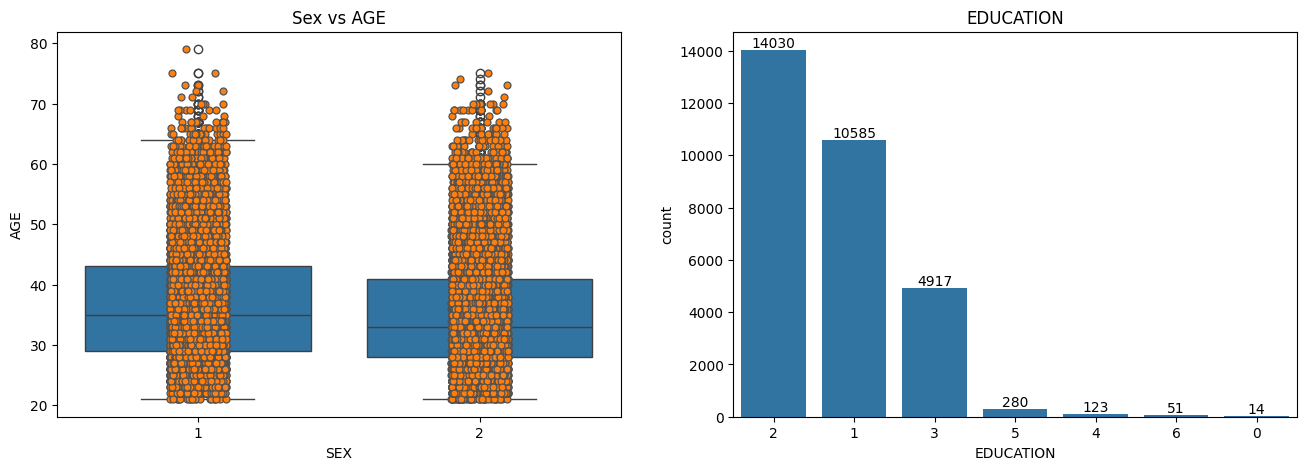

In [112]:
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.boxplot(x='SEX', y= 'AGE',data = data)
sns.stripplot(x='SEX', y= 'AGE',data = data,linewidth = 0.9)
plt.title ('Sex vs AGE')

plt.subplot(122)
ax = sns.countplot(x='EDUCATION',data = data,  order= data['EDUCATION'].value_counts().index)
plt.title ('EDUCATION')
labels = data['EDUCATION'].value_counts()
for i, v in enumerate(labels):
    ax.text(i,v+100,v, horizontalalignment='center')
plt.show()

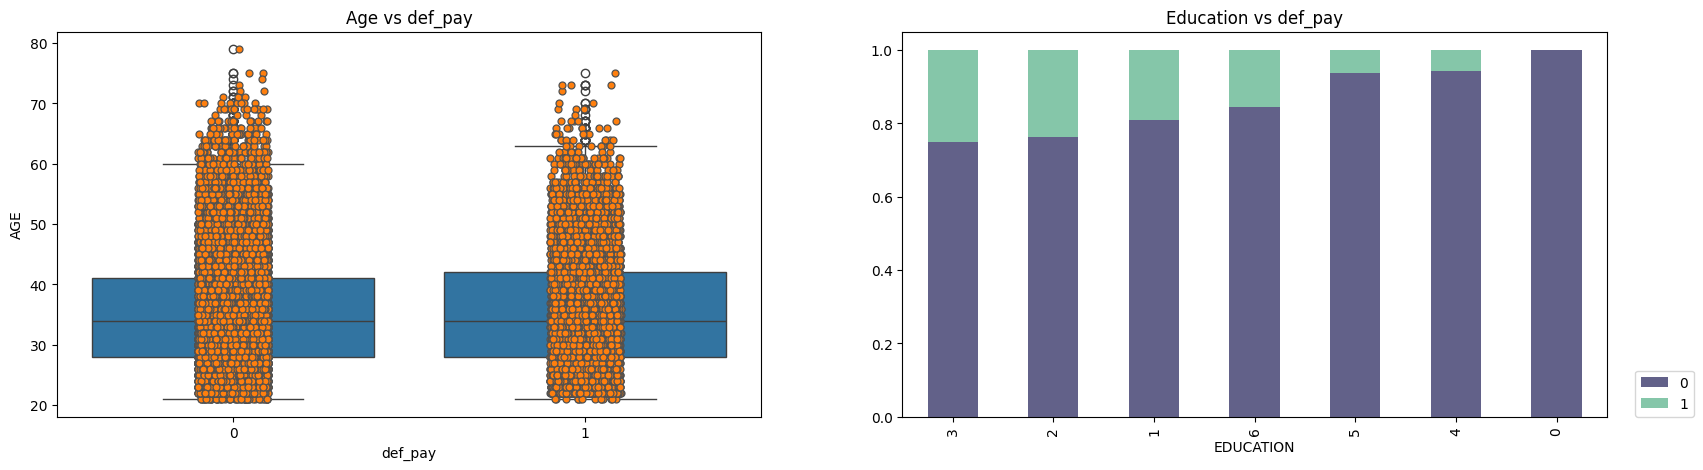

In [113]:
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.boxplot(x='def_pay', y= 'AGE',data = data)
sns.stripplot(x='def_pay', y= 'AGE',data = data,linewidth = 0.9)
plt.title ('Age vs def_pay')

ax2=plt.subplot(1,2,2)
pay_edu = data.groupby('EDUCATION')['def_pay'].value_counts(normalize=True).unstack()
pay_edu = pay_edu.sort_values(ascending=False,by=1)
pay_edu.plot(kind='bar',stacked= True,color=["#3f3e6fd1", "#85c6a9"], ax = ax2)
plt.legend(loc=(1.04,0))
plt.title('Education vs def_pay')
plt.show()

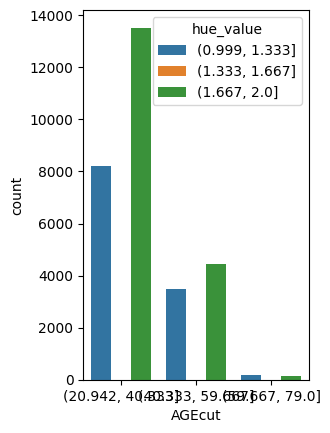

In [118]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# function for Multivariate analysis
# This method is used to show point estimates and confidence intervals using scatter plot graphs
def plotfig(df1,col11,col22,deft1):
    plt.figure(figsize=(16,6))

    plt.subplot(121)
    # Pass data as a DataFrame and specify x, y, and hue as keyword arguments
    sns.pointplot(data=df1, x=col11, y=deft1, hue=col22)

    plt.subplot(122)
    sns.countplot(df1[col11], hue = df1[col22])
    plt.show()

def varplot(df2, col1, col2, deft, bin=0, unique=0):
    df = df2.copy()
    if unique!=0:
        df[col1] = df[col1].apply(lambda x: x if x in df[col1].value_counts().index[:unique] else 'Others')
    if bin !=0:
        df[col1+'cut'] = pd.cut(df[col1],bin)
        if df[col2].dtype == 'O':
            df[col2+'cut']= df[col2]
            # Melt the DataFrame to convert it to long format
            df_melted = pd.melt(df, id_vars=[col1+'cut'], value_vars=[col2+'cut'], var_name='hue_variable', value_name='hue_value')

            # Now use the melted DataFrame for countplot
            plt.subplot(122)
            sns.countplot(data=df_melted, x=col1+'cut', hue='hue_value')
            plt.show()
        else:
            df[col2+'cut'] = pd.cut(df[col2],bin)
            # Melt the DataFrame to convert it to long format
            df_melted = pd.melt(df, id_vars=[col1+'cut'], value_vars=[col2+'cut'], var_name='hue_variable', value_name='hue_value')

            # Now use the melted DataFrame for countplot
            plt.subplot(122)
            sns.countplot(data=df_melted, x=col1+'cut', hue='hue_value')
            plt.show()
    else:
        if df[col2].dtype == 'O':
            # Melt the DataFrame to convert it to long format
            df_melted = pd.melt(df, id_vars=[col1], value_vars=[col2], var_name='hue_variable', value_name='hue_value')

            # Now use the melted DataFrame for countplot
            plt.subplot(122)
            sns.countplot(data=df_melted, x=col1, hue='hue_value')
            plt.show()
        else:
            df[col2+'cut'] = pd.cut(df[col2],5) # Assuming 5 bins if not specified
            # Melt the DataFrame to convert it to long format
            df_melted = pd.melt(df, id_vars=[col1], value_vars=[col2+'cut'], var_name='hue_variable', value_name='hue_value')

            # Now use the melted DataFrame for countplot
            plt.subplot(122)
            sns.countplot(data=df_melted, x=col1, hue='hue_value')
            plt.show()

# Example usage: Assuming 'data' is your DataFrame
varplot(data, 'AGE', 'SEX', 'def_pay', 3)

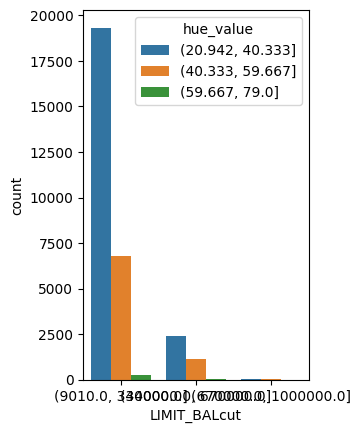

In [119]:
varplot(data,'LIMIT_BAL','AGE','def_pay',3)

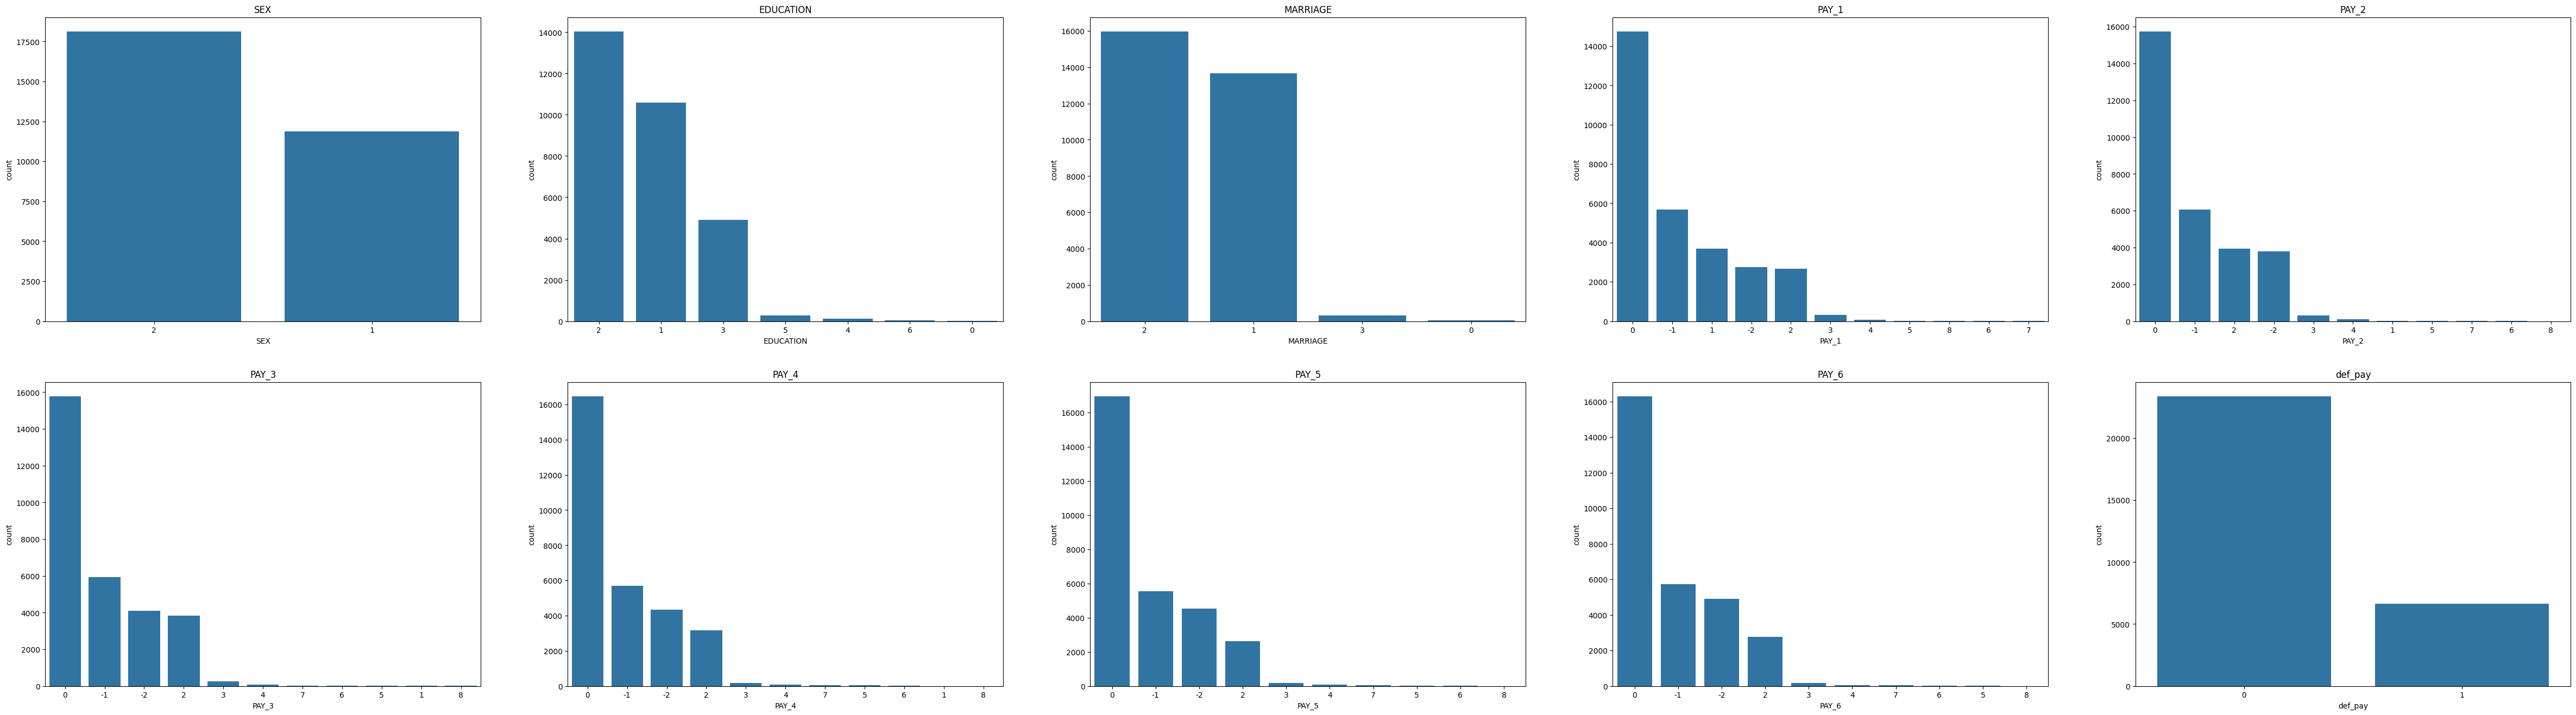

In [123]:


# Univariate Analysis
df = data.drop('ID', axis=1)
nuniq = df.nunique()
df = data[[col for col in df if nuniq[col]>1 and nuniq[col]<50]]
row, cols = df.shape
colnames = list(df)
graph_perrow = 5
# Ensure graph_row is an integer by using floor division //
graph_row = (cols + graph_perrow - 1) // graph_perrow
max_graph = 20
!pip install seaborn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ... (rest of your code)

plt.figure(figsize=(graph_perrow*12,graph_row*8))
for i in range(min(cols,max_graph)):
    plt.subplot(graph_row,graph_perrow,i+1)
    coldf = df.iloc[:,i]
    if (not np.issubdtype(type(coldf),np.number)):
        # Pass the column name as x and the DataFrame as data
        sns.countplot(x=colnames[i], data=df, order=df[colnames[i]].value_counts().index)
    else:
        coldf.hist()
    plt.title(colnames[i])
plt.show()

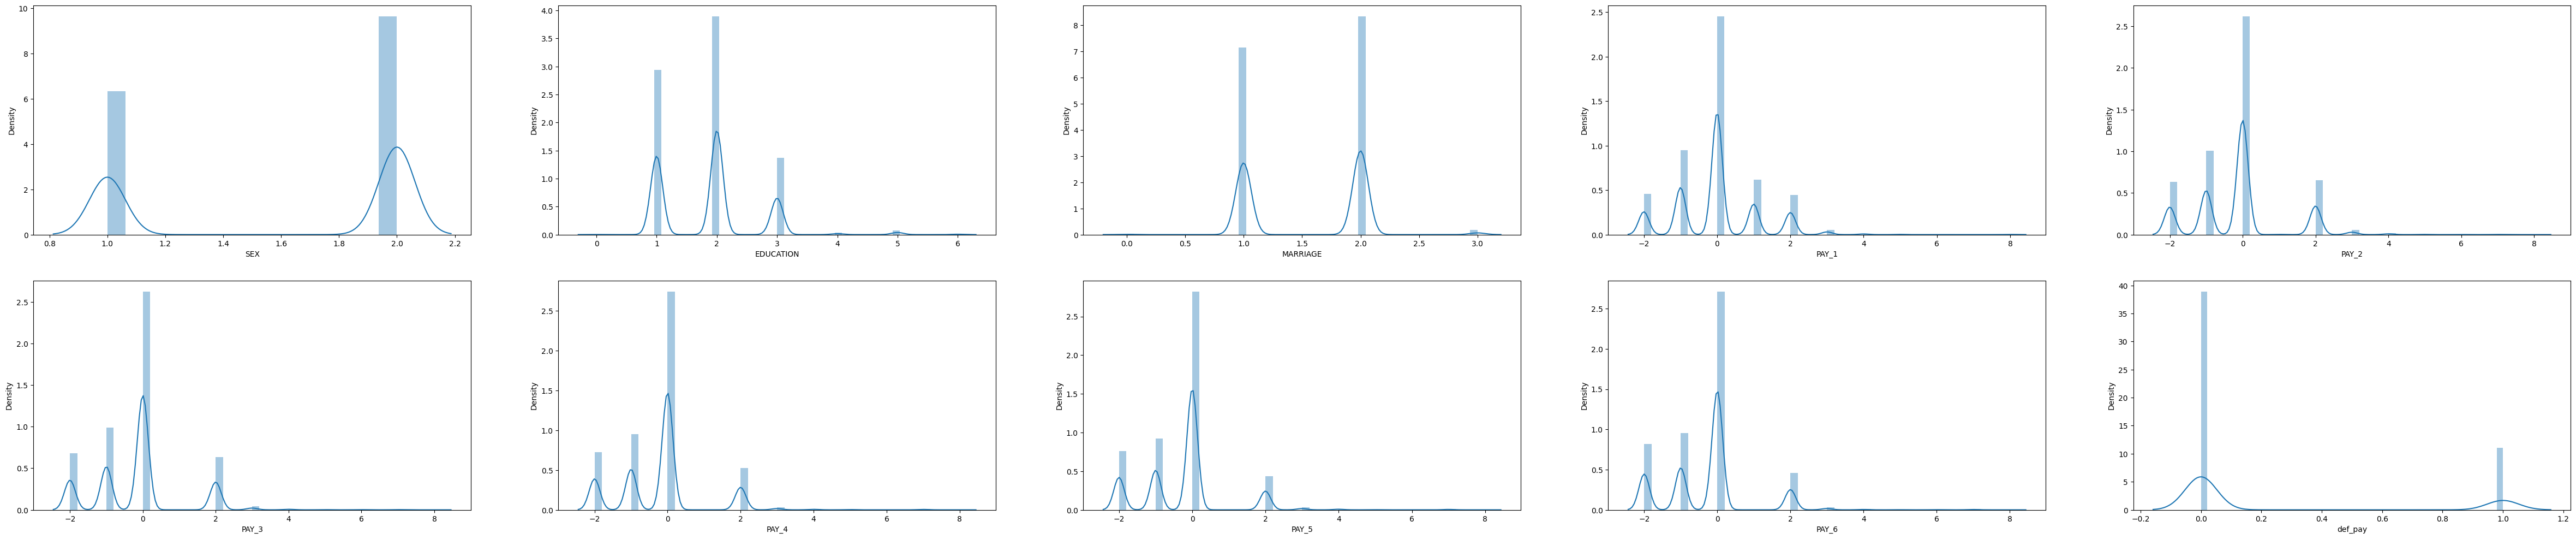

In [125]:
cont_var = df.select_dtypes(exclude='object').columns
# Use the 'ceil' function from the 'math' module to round up to the nearest integer
import math
nrow = math.ceil(len(cont_var)/5)
plt.figure(figsize=(12*5,6*2))
for i,j in enumerate(cont_var):
    plt.subplot(nrow,5,i+1)
    sns.distplot(data[j])
plt.show()

In [126]:
# from the above,we can see that we have maximum clients from 20-30 age group followed by 31-40.
# Hence with increasing age group the number of clients that will default the payment next month is decreasing.
# Hence we can see that Age is important feature to predict the default payment for next month.

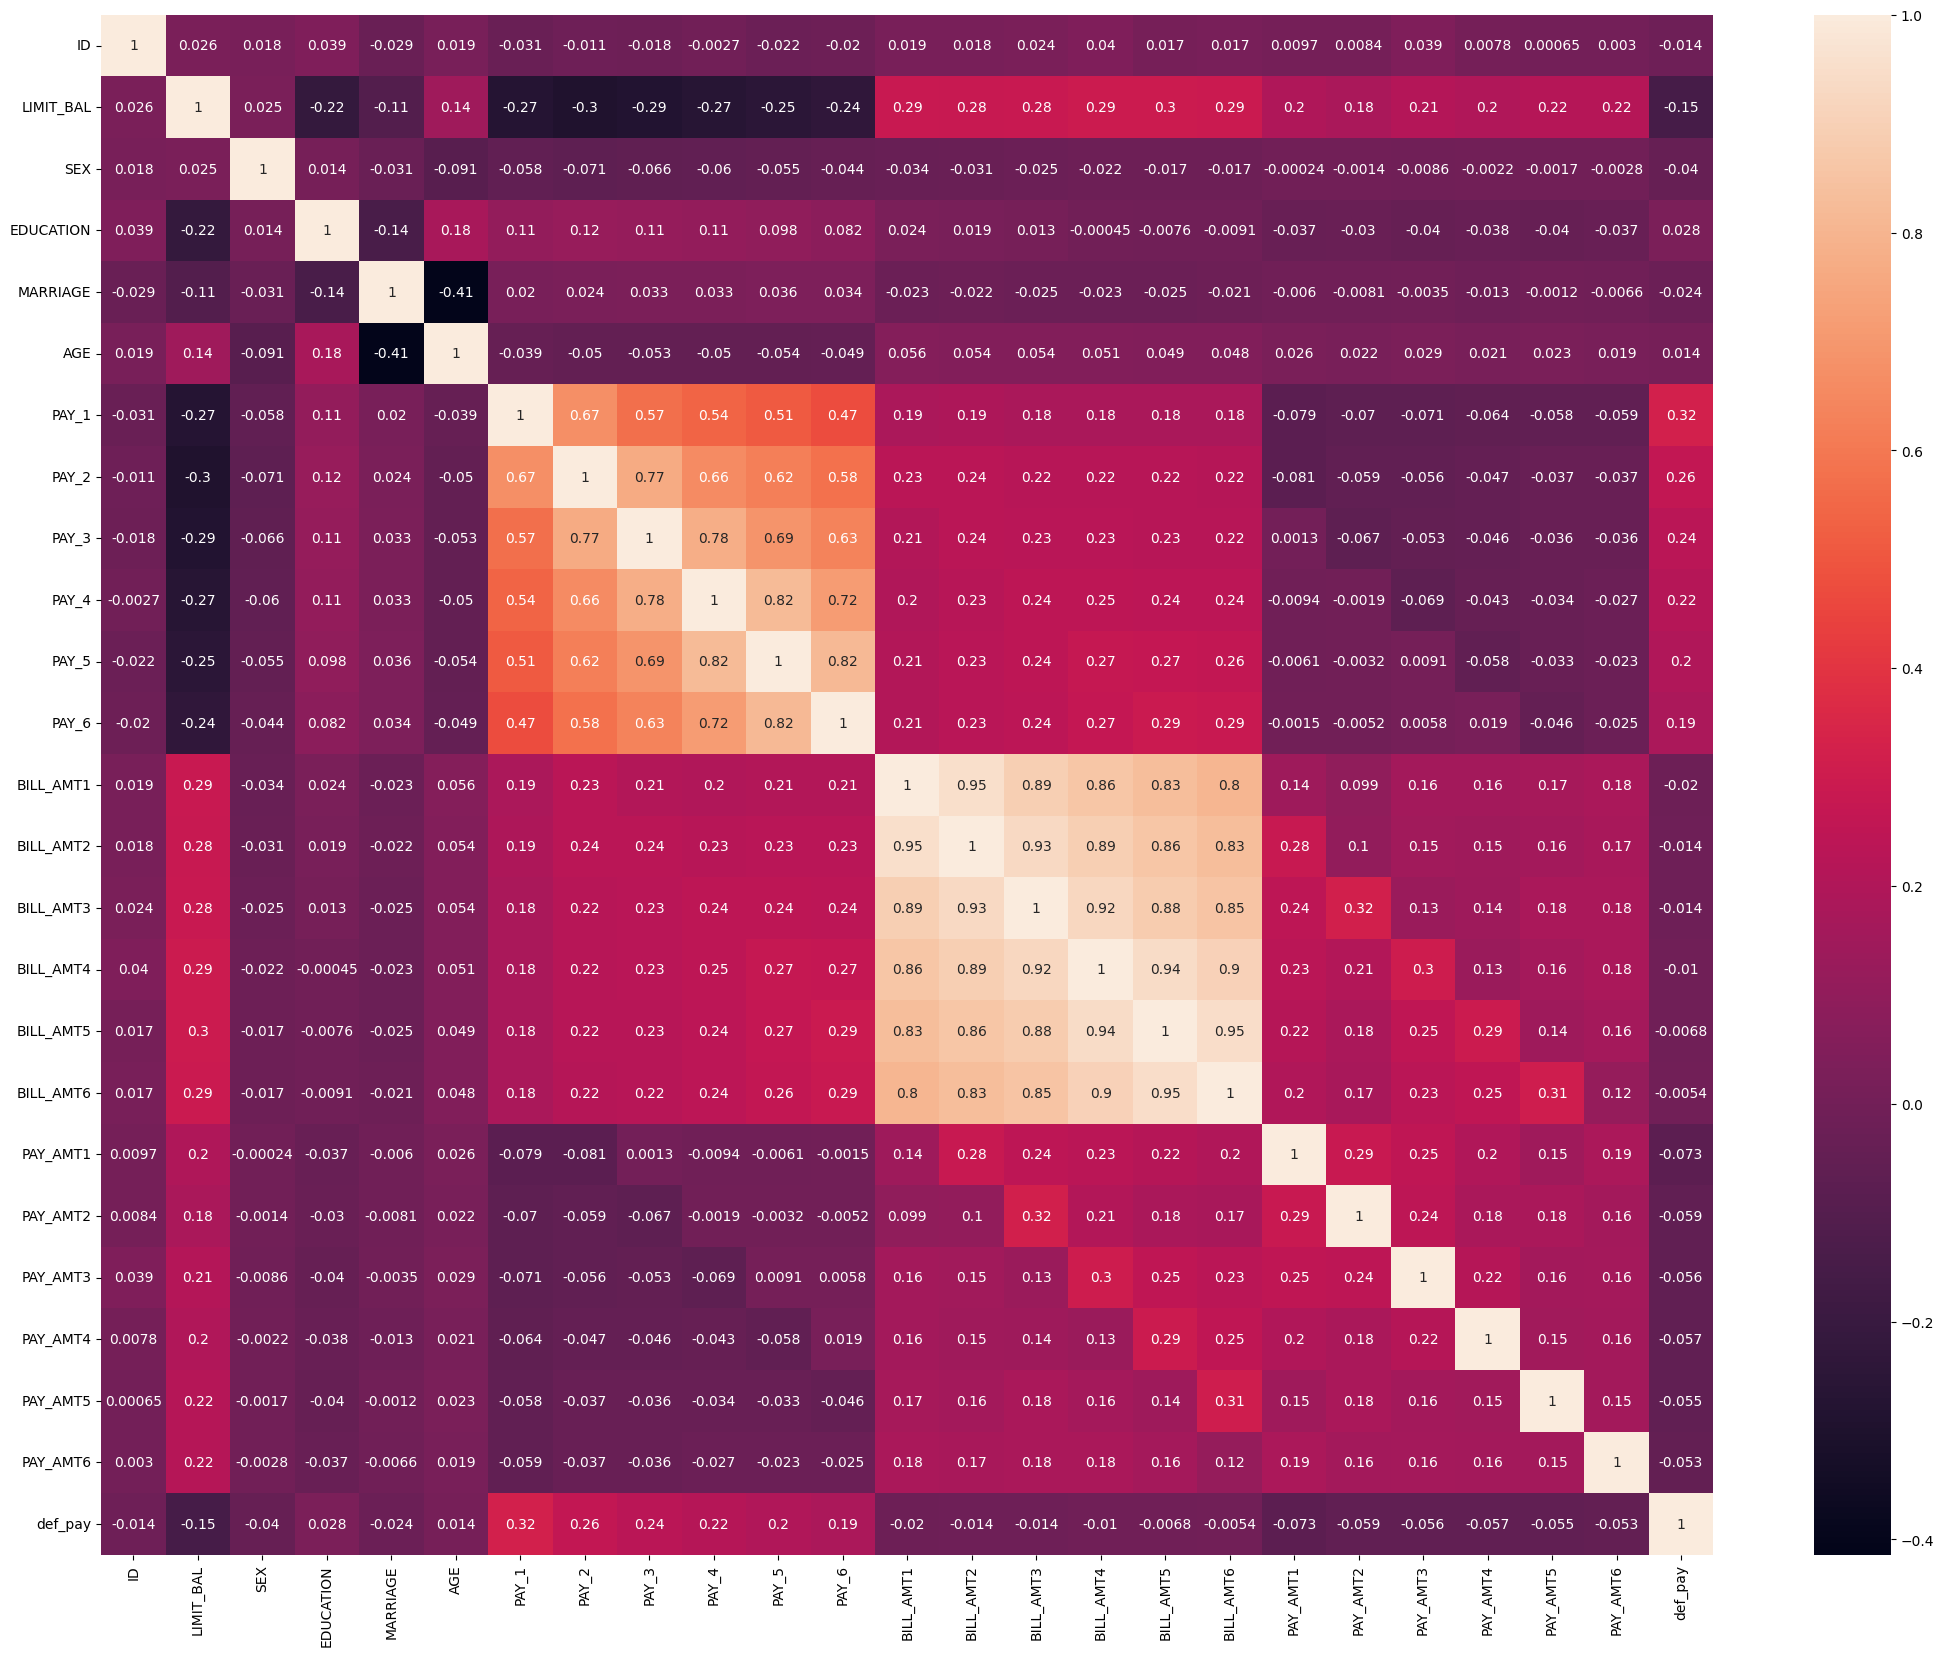

In [127]:
plt.subplots(figsize=(26,20))
corr = data.corr()
sns.heatmap(corr,annot=True)
plt.show()

In [129]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Specify 'axis=1' to drop columns
df = data.drop(['def_pay','ID'], axis=1)
vif = pd.DataFrame()
vif['Features']= df.columns
vif['vif']= [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
vif

,Features,vif
0,LIMIT_BAL,4.037479
1,SEX,9.092210
2,EDUCATION,6.731119
3,MARRIAGE,6.265388
4,AGE,10.857679
5,PAY_1,1.918276
6,PAY_2,3.211217
7,PAY_3,3.727427
8,PAY_4,4.440120
9,PAY_5,4.985856


In [130]:
# From this heatmap and VIF we can see that there are some multicolinearity(values >10) in the data which we can handle
# simply doing feature engineering of some columns

bill_tot = pd.DataFrame(data['BILL_AMT1']+data['BILL_AMT2']+data['BILL_AMT3']+data['BILL_AMT4']+data['BILL_AMT5']+data['BILL_AMT6'],columns=['bill_tot'])
pay_tot =pd.DataFrame(data['PAY_1']+data['PAY_2']+data['PAY_3']+data['PAY_4']+data['PAY_5']+data['PAY_6'],columns=['pay_tot'])
pay_amt_tot = pd.DataFrame(data['PAY_AMT1']+data['PAY_AMT2']+data['PAY_AMT3']+data['PAY_AMT4']+data['PAY_AMT5']+data['PAY_AMT6'],columns=['pay_amt_tot'])
frames=[bill_tot,pay_tot,pay_amt_tot,data['def_pay']]
tot = pd.concat(frames,axis=1)


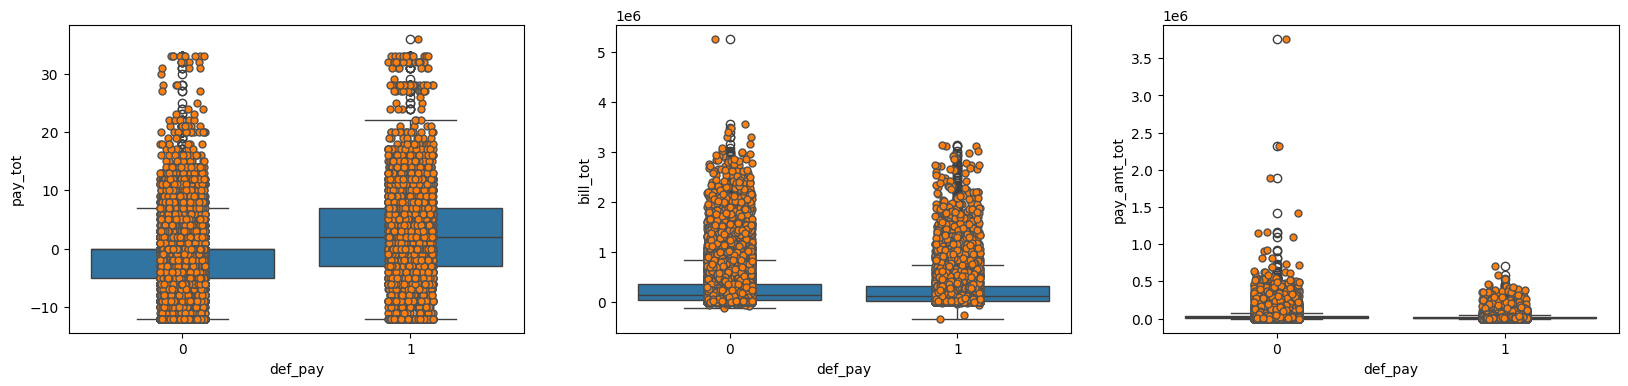

In [131]:
plt.figure(figsize=(20,4))
plt.subplot(131)
sns.boxplot(x='def_pay',y='pay_tot',data = tot)
sns.stripplot(x='def_pay',y='pay_tot',data = tot,linewidth=1)

plt.subplot(132)
sns.boxplot(x='def_pay', y='bill_tot',data=tot)
sns.stripplot(x='def_pay', y='bill_tot',data=tot,linewidth=1)

plt.subplot(133)
sns.boxplot(x='def_pay', y='pay_amt_tot',data=tot)
sns.stripplot(x='def_pay', y='pay_amt_tot',data=tot,linewidth=1)
plt.show()

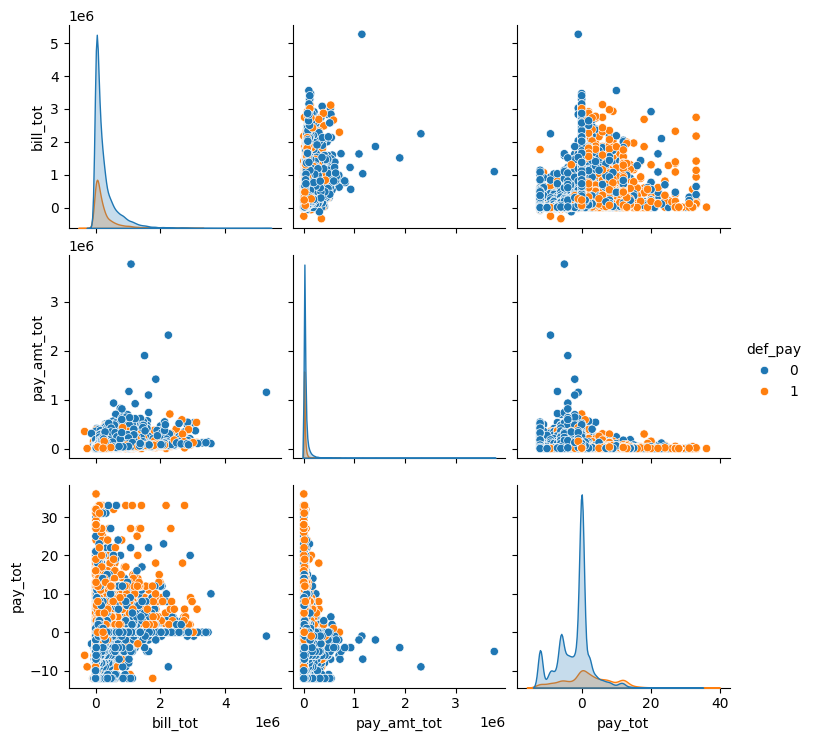

In [132]:
sns.pairplot(tot[['bill_tot','pay_amt_tot','pay_tot','def_pay']],hue='def_pay')
plt.show()

<Axes: xlabel='def_pay', ylabel='bill_tot'>

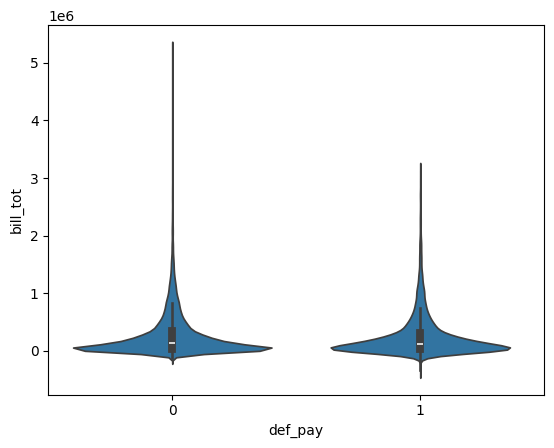

In [133]:
sns.violinplot(x=tot['def_pay'], y= tot['bill_tot'])

In [135]:
tot.drop('def_pay', axis=1, inplace=True)  # Specify 'axis' as a keyword argument

In [137]:
data1 = pd.concat([data,tot], axis = 1)

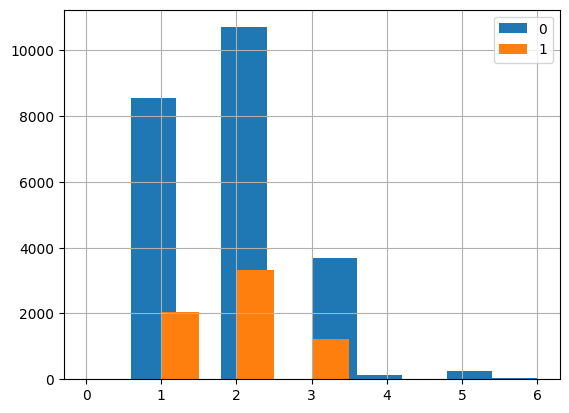

In [138]:
data1.groupby('def_pay')['EDUCATION'].hist(legend=True)
plt.show()

<Figure size 1200x600 with 0 Axes>

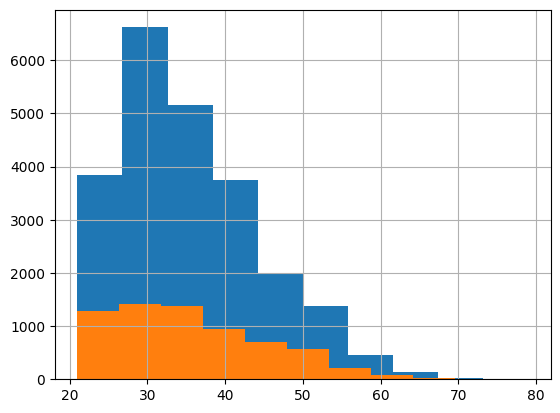

<Figure size 1200x600 with 0 Axes>

In [139]:
data1.groupby('def_pay')['AGE'].hist()
plt.figure(figsize=(12,6))

In [141]:
# we know that the Bill_AMT is the most correlated column so using that we create a data
df = pd.concat([bill_tot,df], axis=1)  # Pass 'axis' as a keyword argument
df1 = df.drop(['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], axis=1)  # Same for the drop function

In [142]:
vif = pd.DataFrame()
vif['Features']= df1.columns
vif['vif']= [variance_inflation_factor(df1.values,i) for i in range(df1.shape[1])]
vif

,Features,vif
0,bill_tot,2.195200
1,LIMIT_BAL,4.021099
2,SEX,9.076043
3,EDUCATION,6.710872
4,MARRIAGE,6.262482
5,AGE,10.857405
6,PAY_1,1.917353
7,PAY_2,3.187792
8,PAY_3,3.706226
9,PAY_4,4.427837


In [143]:
# above we can see that now our data doesnt have multicollinearty(no values >10)

In [144]:
data2 = df1.copy()

In [145]:
# using the above plot we can create age bins
age = [20,27,32,37,42,48,58,64,80]
lab = [8,7,6,5,4,3,2,1]
data2['AGE'] = pd.cut(data2['AGE'],bins= age,labels=lab)

In [147]:
data2 =  pd.concat([data2,data['def_pay']],axis=1) # Pass a single list of objects to concatenate, and specify the axis using 'axis'

<Figure size 1200x600 with 0 Axes>

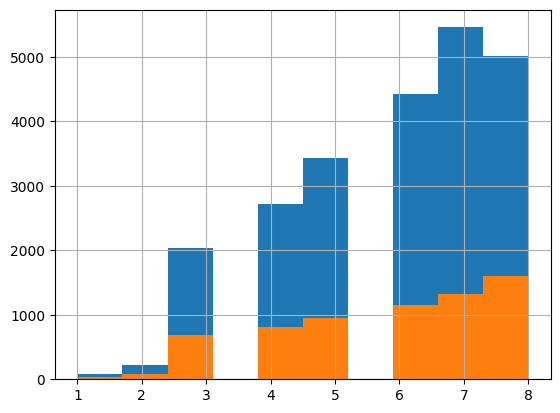

<Figure size 1200x600 with 0 Axes>

In [148]:
data2.groupby('def_pay')['AGE'].hist()
plt.figure(figsize=(12,6))

<Axes: xlabel='count', ylabel='AGE'>

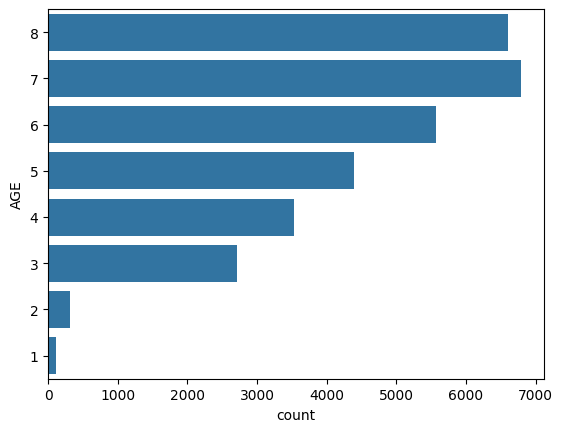

In [149]:
sns.countplot(data2['AGE'])

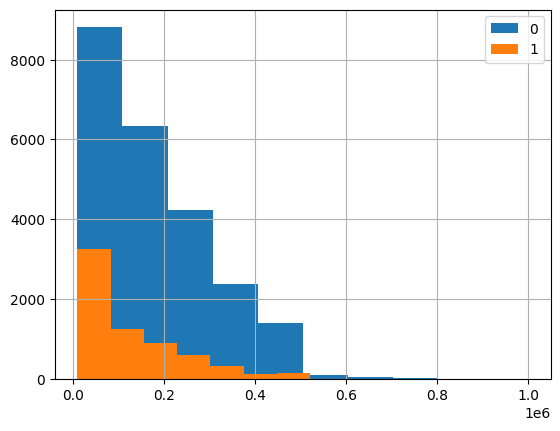

In [150]:
data2.groupby('def_pay')['LIMIT_BAL'].hist(legend=True)
plt.show()

In [151]:
data2.columns

Index(['bill_tot', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'def_pay'],
      dtype='object')

# Model Creation
#### We know that we have a dataset where we have imbalance in the target variable
#### you get a pretty high accuracy just by predicting the majority class, but you fail to capture the minority class
#### which is most often the point of creating the model in the first place.
#### Hence we try to create more model to get the best results

In [153]:
x = data2.drop(['def_pay'], axis=1)  # Specify 'axis' as a keyword argument
y = data2['def_pay']
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.20, random_state=1)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [154]:
# Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading.
# hence we are using Classification Report and Confusion Matrix
# function for accuracy and confusion matrix
def res(y_test_valid,y_train_valid):
    cm_log = confusion_matrix(y_test,y_test_valid)
    ConfusionMatrixDisplay(cm_log).plot()
    print(classification_report(y_test,y_test_valid))
    print('train_accuracy:',accuracy_score(y_train,y_train_valid))
    print('test_accuracy:',accuracy_score(y_test,y_test_valid))

# Logistic model

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      4663
           1       0.72      0.22      0.34      1337

    accuracy                           0.81      6000
   macro avg       0.77      0.60      0.61      6000
weighted avg       0.79      0.81      0.76      6000

train_accuracy: 0.8107916666666667
test_accuracy: 0.8071666666666667


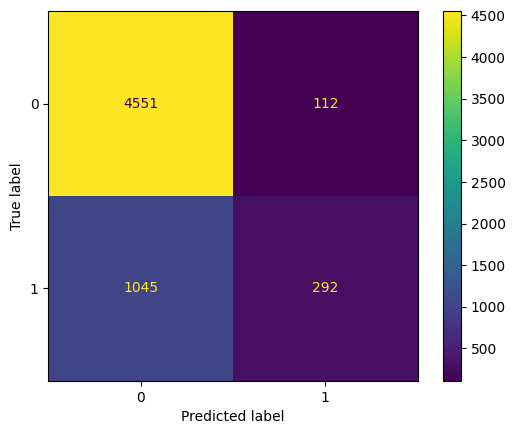

In [155]:
log_model= LogisticRegression()
log_model.fit(x_train,y_train)
y_pred_log = log_model.predict(x_test)
y_pred_train = log_model.predict(x_train)
res(y_pred_log,y_pred_train)

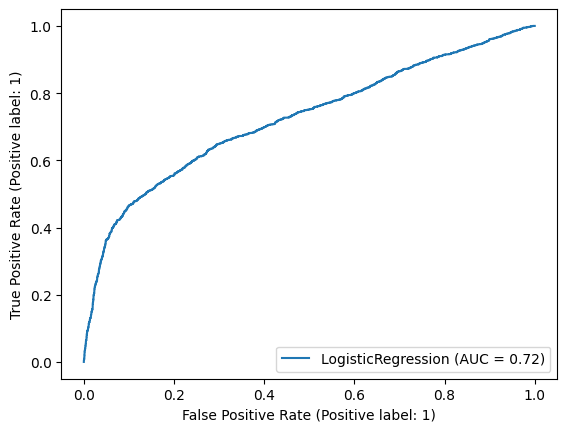

In [158]:
!pip install scikit-learn
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(log_model, x_test, y_test)
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4663
           1       0.64      0.41      0.50      1337

    accuracy                           0.82      6000
   macro avg       0.74      0.67      0.69      6000
weighted avg       0.80      0.82      0.80      6000

train_accuracy: 0.8137083333333334
test_accuracy: 0.8158333333333333


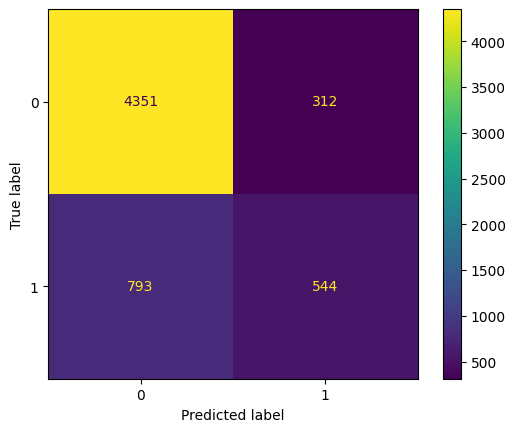

In [159]:
# log model using Threshold
threshold = 0.36
y_log_prob =  log_model.predict_proba(x_test)
y_train_log_prob = log_model.predict_proba(x_train)
y_log_prob=y_log_prob[:,1]
y_train_log_prob= y_train_log_prob[:,1]
y_pred_log_prob = np.where(y_log_prob>threshold,1,0)
y_pred_log_prob_train = np.where(y_train_log_prob>threshold,1,0)
res(y_pred_log_prob,y_pred_log_prob_train)

# using Decision Tree model

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      4663
           1       0.37      0.40      0.38      1337

    accuracy                           0.71      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.72      0.71      0.72      6000

train_accuracy: 0.9977083333333333
test_accuracy: 0.7136666666666667


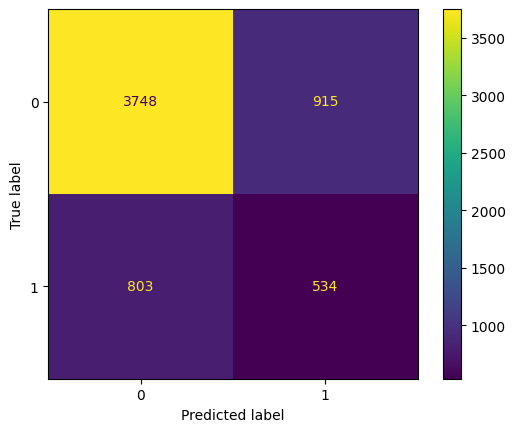

In [160]:
dec_model = DecisionTreeClassifier()
dec_model.fit(x_train,y_train)
y_pred_dec = dec_model.predict(x_test)
y_pred_dec_train = dec_model.predict(x_train)
res(y_pred_dec,y_pred_dec_train)

### Hyper parameter tuning for DecisionTree

In [161]:
parameters = {'max_depth':[1,2,3,4,5,6],'min_samples_split':[3,4,5,6,7],'min_samples_leaf':[1,2,3,4,5,6]}
tree = GridSearchCV(dec_model, parameters,cv=10)
tree.fit(x_train,y_train)
tree.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4663
           1       0.68      0.35      0.46      1337

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.79      6000

train_accuracy: 0.824375
test_accuracy: 0.8183333333333334


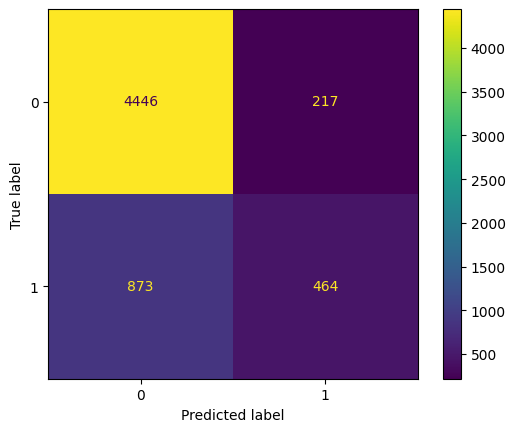

In [162]:
# We know that Decision tree will have high variance due to which the model overfit hence we can reduce this by "Pruning"
# By using the best parameter from GridSearchCV best parameters
dec_model1 = DecisionTreeClassifier(max_depth=4,min_samples_split=10,min_samples_leaf=1)
dec_model1.fit(x_train,y_train)
y_pred_dec1 = dec_model1.predict(x_test)
y_pred_dec_train1 = dec_model1.predict(x_train)
res(y_pred_dec1,y_pred_dec_train1)

# Random Forest Model

              precision    recall  f1-score   support

           0       0.83      0.94      0.89      4663
           1       0.64      0.35      0.45      1337

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

train_accuracy: 0.9976666666666667
test_accuracy: 0.812


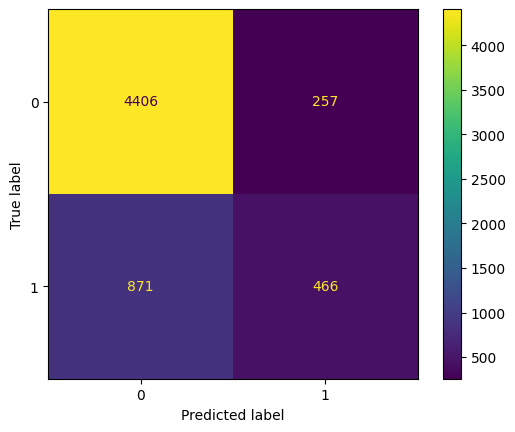

In [163]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(x_train,y_train)
y_pred_rf = rf_model.predict(x_test)
y_pred_rf_train = rf_model.predict(x_train)
res(y_pred_rf,y_pred_rf_train)

### Again hyper parameter tuning for Random Forest

In [164]:
# parameters = {'n_estimators':[60,70,80],'max_depth':[1,2,3,4,5,6],'min_samples_split':[3,4,5,6,7],
#               'min_samples_leaf':[1,2,3,4,5,6]}
# clf = GridSearchCV(rf_model, parameters,cv=10)
# clf.fit(x_train,y_train)
# clf.best_params_
    # {'max_depth': 5,
    #  'min_samples_leaf': 4,
    #  'min_samples_split': 3,
    #  'n_estimators': 70}

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4663
           1       0.69      0.32      0.43      1337

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000

train_accuracy: 0.8227083333333334
test_accuracy: 0.8156666666666667


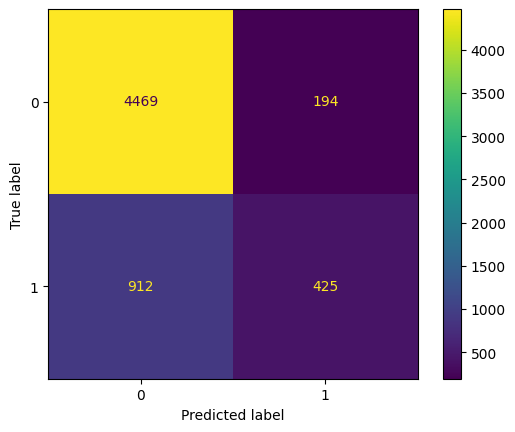

In [165]:
# Decision trees frequently perform well on imbalanced data. so using RandomForest uses bagging of n_trees will be a better idea.
rf_model = RandomForestClassifier(n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3)
rf_model.fit(x_train,y_train)
y_pred_rf = rf_model.predict(x_test)
y_pred_rf_train = rf_model.predict(x_train)
res(y_pred_rf,y_pred_rf_train)

# KNN model

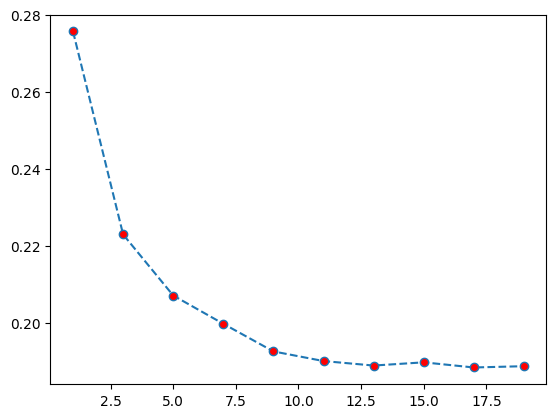

In [166]:
# finding the K value
error = []

for i in range(1,21,2):
    knn =  KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    preds = knn.predict(x_test)
    error.append(np.mean(preds!=y_test))

plt.plot(range(1,21,2), error, linestyle = 'dashed', marker ='o', mfc= 'red')

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4663
           1       0.56      0.34      0.43      1337

    accuracy                           0.79      6000
   macro avg       0.69      0.63      0.65      6000
weighted avg       0.77      0.79      0.77      6000

train_accuracy: 0.8432916666666667
test_accuracy: 0.7928333333333333


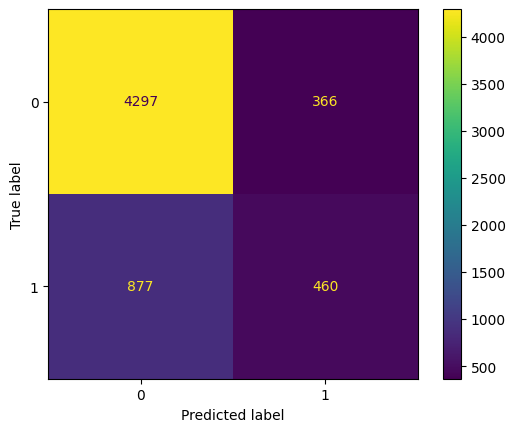

In [167]:
# By using the elbow graph we can see that the k=5 will perform better in the first place so impute k = 5
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train,y_train)
y_pred_knn = knn_model.predict(x_test)
y_pred_knn_train = knn_model.predict(x_train)

res(y_pred_knn,y_pred_knn_train)

# SVM Model

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4663
           1       0.49      0.56      0.52      1337

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.78      0.77      0.78      6000

train_accuracy: 0.7889583333333333
test_accuracy: 0.7743333333333333


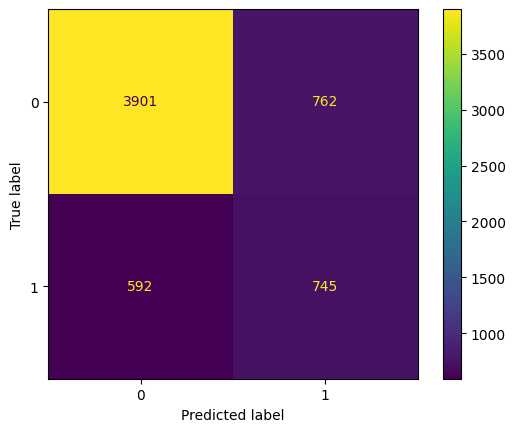

In [168]:
# use penalized learning algorithms that increase the cost of classification mistakes on the minority class.
svm_model = SVC(class_weight='balanced', probability=True)
svm_model.fit(x_train,y_train)
y_pred_svm = svm_model.predict(x_test)
y_pred_svm_train = svm_model.predict(x_train)
res(y_pred_svm,y_pred_svm_train)

In [169]:
# we can see in SVM that our recall of target variable is 0.56 which is the best we ever predicted.

# Naive Bayes

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      4663
           1       0.45      0.61      0.52      1337

    accuracy                           0.74      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.74      0.76      6000

train_accuracy: 0.743375
test_accuracy: 0.7448333333333333


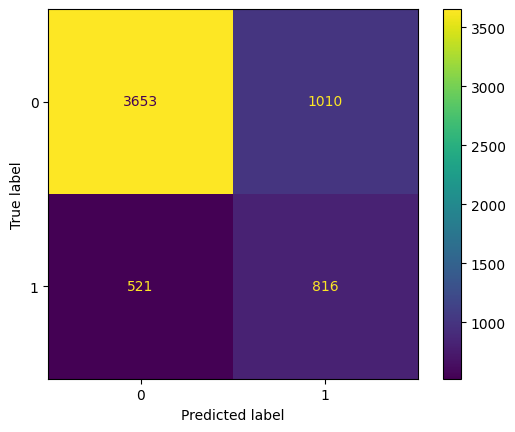

In [170]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)
y_pred_nb = nb_model.predict(x_test)
y_pred_nb_train = nb_model.predict(x_train)
res(y_pred_nb,y_pred_nb_train)

In [171]:
# But here Naive bayes out performs every other model though over accuracy is acceptable, checkout the recall

# Boosting model XGB Classifier

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4663
           1       0.64      0.36      0.46      1337

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

train_accuracy: 0.8813333333333333
test_accuracy: 0.8126666666666666


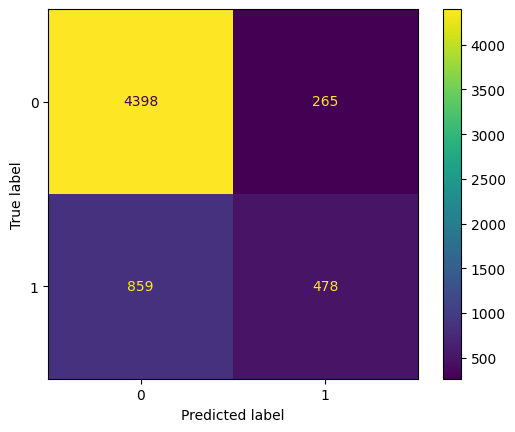

In [172]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
xgb_y_predict = xgb_model.predict(x_test)
xgb_y_predict_train = xgb_model.predict(x_train)
res(xgb_y_predict,xgb_y_predict_train)

In [173]:
# Even Boosting technique gives low recall for our target variable

In [174]:
# So from the above model we can conclude that the data imbalance is playing a major part
# Hence we try to fix that by doing ReSample techniques

# Random under-sampling
### Let’s apply some of these resampling techniques, using the Python library imbalanced-learn.

In [175]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks

In [177]:
x= data2.drop(['def_pay'], axis=1) # Use named argument for clarity
y = data2['def_pay']

rus = RandomUnderSampler(random_state=1)
x_rus, y_rus = rus.fit_resample(x,y)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 23364, 1: 6636})
Resample dataset shape Counter({0: 6636, 1: 6636})


In [178]:
x_train,x_test, y_train, y_test = train_test_split(x_rus,y_rus,test_size=0.20, random_state=1)
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1364
           1       0.78      0.62      0.69      1291

    accuracy                           0.73      2655
   macro avg       0.74      0.73      0.72      2655
weighted avg       0.74      0.73      0.73      2655

train_accuracy: 0.719318074785721
test_accuracy: 0.7295668549905838


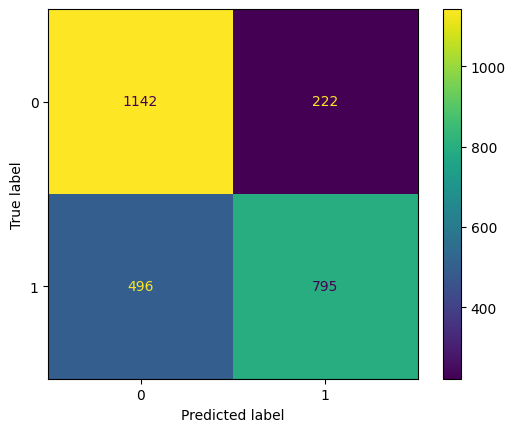

In [179]:
# again we try to predict using Random Forest
rf_model_rus = RandomForestClassifier(n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3,random_state=1)
rf_model_rus.fit(x_train,y_train)
y_pred_rf_rus = rf_model_rus.predict(x_test)
y_pred_rf_rus_train = rf_model_rus.predict(x_train)
res(y_pred_rf_rus,y_pred_rf_rus_train)

# Random over-sampling

In [181]:
x = data2.drop(['def_pay'], axis=1) # Use named argument 'axis' to specify column drop
y = data2['def_pay']

ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 23364, 1: 6636})
Resample dataset shape Counter({1: 23364, 0: 23364})


In [182]:
x_train,x_test, y_train, y_test = train_test_split(x_ros,y_ros,test_size=0.20, random_state=1)
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

              precision    recall  f1-score   support

           0       0.67      0.82      0.74      4607
           1       0.77      0.62      0.69      4739

    accuracy                           0.71      9346
   macro avg       0.72      0.72      0.71      9346
weighted avg       0.72      0.71      0.71      9346

train_accuracy: 0.7182066235086405
test_accuracy: 0.7138882944575219


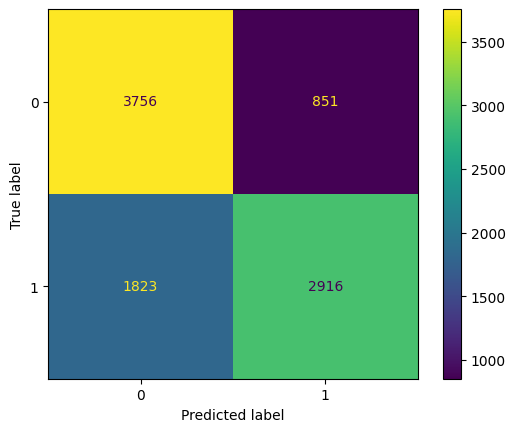

In [183]:
rf_model_ros = RandomForestClassifier(n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3,random_state=1)
rf_model_ros.fit(x_train,y_train)
y_pred_rf_ros = rf_model_ros.predict(x_test)
y_pred_rf_ros_train = rf_model_ros.predict(x_train)
res(y_pred_rf_ros,y_pred_rf_ros_train)

# Under-sampling: Tomek links

In [184]:
x= data2.drop(['def_pay'],axis = 1)
y = data2['def_pay']

tl = TomekLinks(sampling_strategy='majority')
x_tl, y_tl = tl.fit_resample(x,y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_tl))

Original dataset shape Counter({0: 23364, 1: 6636})
Resample dataset shape Counter({0: 21484, 1: 6636})


In [185]:
x_train,x_test, y_train, y_test = train_test_split(x_tl,y_tl,test_size=0.20, random_state=1)
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4306
           1       0.69      0.37      0.48      1318

    accuracy                           0.81      5624
   macro avg       0.76      0.66      0.68      5624
weighted avg       0.80      0.81      0.79      5624

train_accuracy: 0.8185455192034139
test_accuracy: 0.8129445234708392


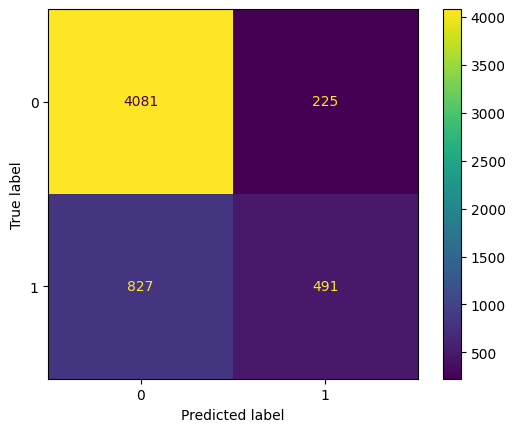

In [186]:
rf_model_tl = RandomForestClassifier(n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3,random_state=1)
rf_model_tl.fit(x_train,y_train)
y_pred_rf_tl = rf_model_tl.predict(x_test)
y_pred_rf_tl_train = rf_model_tl.predict(x_train)
res(y_pred_rf_tl,y_pred_rf_tl_train)

# Synthetic Minority Oversampling Technique (SMOTE)

In [187]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

x_smote, y_smote = smote.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 23364, 1: 6636})
Resample dataset shape Counter({1: 23364, 0: 23364})


In [188]:
x_train,x_test, y_train, y_test = train_test_split(x_smote,y_smote,test_size=0.20, random_state=1)
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [189]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      4607
           1       0.87      0.79      0.83      4739

    accuracy                           0.83      9346
   macro avg       0.84      0.83      0.83      9346
weighted avg       0.84      0.83      0.83      9346

train_accuracy: 0.8354555668503558
test_accuracy: 0.833832655681575


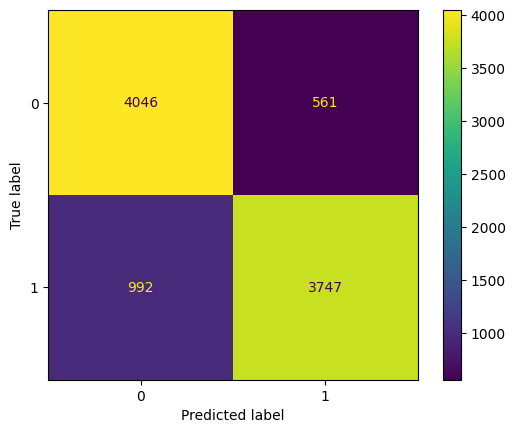

In [190]:
rf_model_smote = RandomForestClassifier(n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3,random_state=1)
rf_model_smote.fit(x_train,y_train)
y_pred_rf_smote = rf_model_smote.predict(x_test)
y_pred_rf_smote_train = rf_model_smote.predict(x_train)
res(y_pred_rf_smote,y_pred_rf_smote_train)

### Finally using SMOTE we can see our accuracy as well as recall and precision ratio are give equal ratio
### Though all the above models performs well, based on the accuracy  but in a imbalance dataset like this,
####              we actually prefer to change the performance metrics
### We can get better result when we do SVM and Naive bayes with our original data
### Even we dont have any variance in the model nor to much of bias
### But when we do over or Under sample the date the other metrics like sensity and specificity was better
### Hence we can conclue that if we use resample technique we will get better result